#  Прогнозирование заказов такси

# Цель и описание проекта

Мы работаем с компанией «Чётенькое такси». Эта компания предоставила нам исторические данные о заказах такси в аэропортах. Наша главная задача - спрогнозировать количество заказов такси на следующий час. Для этого нужно найти модель, которая предскажет количество заказов на следующий час.

# Содержание


- [1. Подготовка и анализ.](#load)
- [2. Обучение моделей.](#learning)
    -  [2.1 LinearRegression](#linear)
    -  [2.2 LightGBMRegressor](#light)
    -  [2.3 CatBoostRegressor](#cat)
-  [3. Тестовая выборка.](#test)

<a id=load></a>
## 1. Подготовка и анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import catboost as cb

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('C://Users/User/Downloads//taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
print('Размер датафрейма:', df.shape[0], 'строк и ', df.shape[1], 'столбцов.')
print('---------------------------------------------------------------\n')
display(df.head())
print('---------------------------------------------------------------\n')
display(df.info())
print('---------------------------------------------------------------\n')
display(df.describe())
print('---------------------------------------------------------------\n')
print('Дубликатов в датафрейме:', df.duplicated().sum())
print('---------------------------------------------------------------\n')
display('Больше всего пропущенных значений в столбцах:', df.isna().sum().sort_values(ascending=False).head(10))
print('---------------------------------------------------------------\n')

Размер датафрейма: 26496 строк и  1 столбцов.
---------------------------------------------------------------



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

---------------------------------------------------------------



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


---------------------------------------------------------------

Дубликатов в датафрейме: 26415
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

num_orders    0
dtype: int64

---------------------------------------------------------------



In [4]:
print(df.index.is_monotonic) #проверим, все ли даты в данных расположены хронологически

True


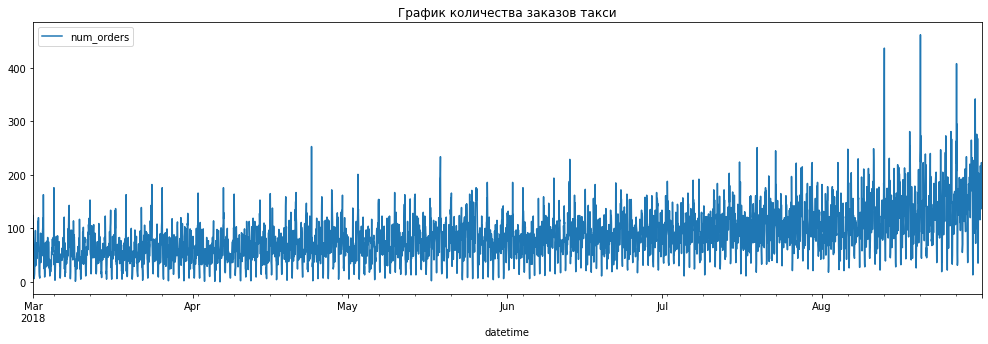

In [5]:
df_resampled = df.resample('1H').sum()  #выполним ресемплирование по одному часу
df_resampled.plot(figsize=(17,5))
plt.title('График количества заказов такси');

In [6]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = df_resampled['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


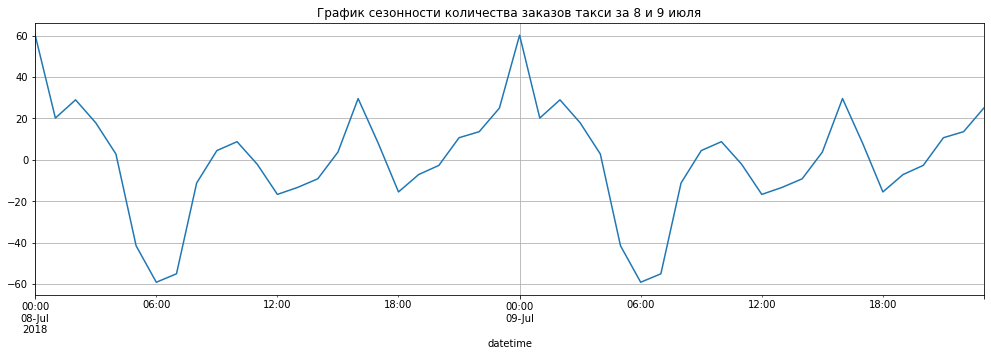

In [7]:
decomposed = seasonal_decompose(df_resampled)

decomposed.seasonal['2018-7-8':'2018-7-9'].plot(figsize=(17,5), grid=True)
plt.title('График сезонности количества заказов такси за 8 и 9 июля');  #взглянем на сезонность случаных 
                                                                             #двух дней из выборки

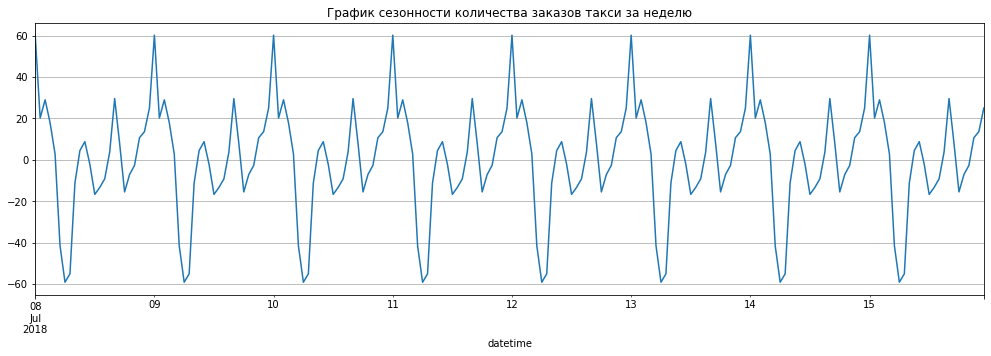

In [8]:
decomposed.seasonal['2018-7-8':'2018-7-15'].plot(figsize=(17,5), grid=True)
plt.title('График сезонности количества заказов такси за неделю');

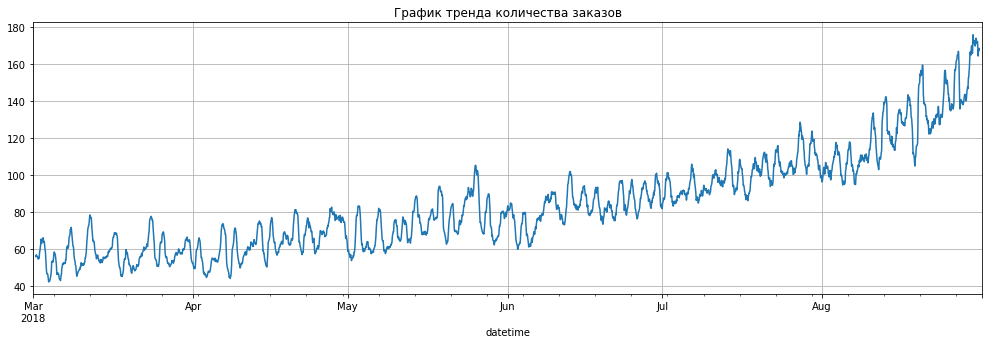

In [9]:
decomposed.trend['2018-1-1':'2018-8-31'].plot(figsize=(17,5), grid=True)
plt.title('График тренда количества заказов');

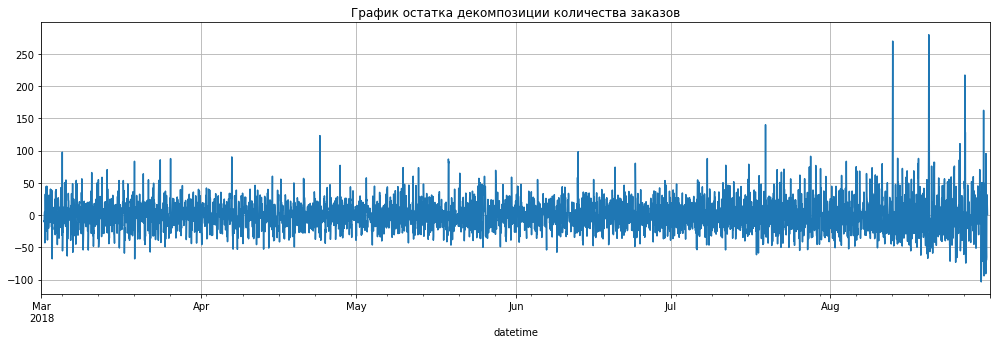

In [10]:
decomposed.resid['2018-1-1':'2018-8-31'].plot(figsize=(17,5), grid=True)
plt.title('График остатка декомпозиции количества заказов');

### Промежуточный вывод:

Мы имеем дело с небольшим датафреймом, в котором 26.5 тысяч строк и всего две колонки. Мы взяли одну из колонок с датой и временем за индекс. 

Дубликатов нет, как и пропущенных значений. Выражена дневная сезонность - пик заказов приходится на 0 часов ночи, а самое низкое количество заказов наблюдается около 6 утра. Также имеется тренд к увеличению количества заказов - с мая по август их становится значительно больше. Остатки по датасету распространены достаточно ровно.

<a id=learning></a>
## 2. Обучение моделей

Сначала проверим константную модель и модель, которая будет "предсказывать", подставляя количество заказов предыдущего часа.

In [11]:
train, test = train_test_split(df_resampled, shuffle=False, test_size=0.1)

In [12]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_previous = test.shift(fill_value=train.iloc[-1,0]) #добавим в переменную количество заказов за прошлый относительно индекса час
print("RMSE с предыдущим значением:", np.sqrt(mean_squared_error(test, pred_previous))) #проверим RMSE с этим значением

pred_median = np.ones(test.shape) * train['num_orders'].median() #добавим в переменную медиану по признаку с количеством заказов
print("RMSE с константой:", np.sqrt(mean_squared_error(test, pred_median)))

Среднее количество заказов в час: 139.55656108597285
RMSE с предыдущим значением: 58.856486242815066
RMSE с константой: 87.15277582981295


Как мы видим, данные модели не годятся.

Напишем функцию, которая преобразует наши данные в данные удобные для обучения моделей.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_resampled, 10, 10)

In [14]:
train, test = train_test_split(df_resampled, shuffle=False, train_size=0.8, random_state=641)
train = train.dropna()
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

<a id=linear></a>
### 2.1 LinearRegression

In [15]:
model = LinearRegression()

model.fit(features_train, target_train)
preds_train = model.predict(features_train)

print("RMSE обучающей выборки:", np.sqrt(mean_squared_error(target_train, preds_train)))

RMSE обучающей выборки: 29.427294781303402


<a id=light></a>
### 2.2 LGBMRegressor

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
%%time

lgb_model = lgb.LGBMRegressor()

params = {'task' : ['predict'],
     'objective': ['root_mean_squared_error'],
     'num_iterations': [200],
     'learning_rate':[0.03, 0.1],
    'num_leaves':[31, 46],
    'max_depth' :[10, 15]}

tscv = TimeSeriesSplit(n_splits=10, gap=10)
gsearch_lgb = GridSearchCV(estimator=lgb_model, cv=tscv, param_grid=params)
gsearch_lgb.fit(features_train, target_train);

CPU times: user 2min 56s, sys: 1.55 s, total: 2min 57s
Wall time: 2min 58s


GridSearchCV(cv=TimeSeriesSplit(gap=10, max_train_size=None, n_splits=10, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.03, 0.1], 'max_depth': [10, 15],
                         'num_iterations': [200], 'num_leaves': [31, 46],
                         'objective': ['root_mean_squared_error'],
                         'task': ['predict']})

In [22]:
print('Наиболее удачная модель LGBMRegressor имеет параметры:')
print (gsearch_lgb.best_params_)
print('cv results:')
results = pd.DataFrame({
        "mean_test_score": gsearch_lgb.cv_results_["mean_test_score"],
        "mean_fit_time": gsearch_lgb.cv_results_["mean_fit_time"]})\
        .join(pd.io.json.json_normalize(gsearch_lgb.cv_results_["params"]).add_prefix("param_"))
results

Наиболее удачная модель LGBMRegressor имеет параметры:
{'learning_rate': 0.03, 'max_depth': 10, 'num_iterations': 200, 'num_leaves': 31, 'objective': 'root_mean_squared_error', 'task': 'predict'}
cv results:


,mean_test_score,mean_fit_time,param_learning_rate,param_max_depth,param_num_iterations,param_num_leaves,param_objective,param_task
0,0.494863,3.738548,0.03,10,200,31,root_mean_squared_error,predict
1,0.494375,1.489440,0.03,10,200,46,root_mean_squared_error,predict
2,0.493363,1.446534,0.03,15,200,31,root_mean_squared_error,predict
3,0.493969,2.368878,0.03,15,200,46,root_mean_squared_error,predict
4,0.469871,1.142521,0.10,10,200,31,root_mean_squared_error,predict
5,0.468343,1.417503,0.10,10,200,46,root_mean_squared_error,predict
6,0.476088,1.330000,0.10,15,200,31,root_mean_squared_error,predict
7,0.467461,3.901077,0.10,15,200,46,root_mean_squared_error,predict


<a id=cat></a>
### 2.3 CatBoostRegressor

In [19]:
train_dataset = cb.Pool(features_train, target_train)

In [ ]:
%%time

grid = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [10, 15],
        'num_leaves': [31, 62]
       }
tscv = TimeSeriesSplit(n_splits=10, gap=10)
model_cb = cb.CatBoostRegressor(loss_function='RMSE', verbose=100, early_stopping_rounds=20)
gsearch_cb = GridSearchCV(estimator=model_cb, cv=tscv, param_grid=grid)
gsearch_cb.fit(features_train, target_train);

#grid_search_result = model_cb.grid_search(grid, train_dataset, plot=True, cv=tscv)


In [ ]:
print('Наиболее удачная модель CatBoostRegressor имеет параметры:')
print (gsearch_cb.best_params_)

Самой перспективной моделью является модель `LightGBM`, наиболее удачные гиперпараметры: *'learning_rate': 0.03, 'max_depth': 10, 'num_iterations': 200, 'num_leaves': 31.* Также стоит отметить, что она обучается в разы быстрее другого бустинга - CatBoost.

<a id=test></a>
# 3. Проверка на тестовой выборке

In [ ]:
print('LinearRegression:')
pred_lr = model.predict(features_test)
rmse_lr = (np.sqrt(mean_squared_error(target_test, pred_lr)))
print(f'RMSE LinearRegression: {rmse_lr}')
print('-----------------------------------------------------------\n')
print('CatBoost:')
pred_cb_test = gsearch_cb.predict(features_test)
rmse_cb_test = (np.sqrt(mean_squared_error(target_test, pred_cb_test)))
print(f'RMSE CatBoostRegressor: {rmse_cb_test}')
print('-----------------------------------------------------------\n')
print('LightGBM')
pred_lgbm_test = gsearch_lgb.predict(features_test)
rmse_lgbm_test = (np.sqrt(mean_squared_error(target_test, pred_lgbm_test)))
print(f'RMSE LGBMRegressor: {rmse_lgbm_test}')

## Общий вывод:
Мы исследовали исторические данные по количеству заказов такси, подготовили данные для обучения моделей и обучили  три модели: LightGBM, CatBoost и Линейную регрессию. Также, мы проверили, что будет, если в предсказание просто подставить предыдущее значение и проверили константную модель с медианным значением.
Самый точный результат показала модель `LightGBM` - среднеквадратичная ошибка составила **44.4**. 

Остальные модели либо дольше обучались, либо показали более низкий результат:
`Линейная регрессия` - **49.3**, `CatBoost` - **47.9**.